In [66]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [67]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [69]:
df = pd.read_csv("/kaggle/input/dataset-uts-no-2/data_1A.csv")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,text,label
0,The Theory of Everything Review Stephen Hawkin...,Books
1,Computer Networks: A Top - Down Approach About...,Books
2,Sajani Premium Quality Brown Wooden Coat Hange...,Household
3,Bosch Lifestyle MCM3501M 800-Watt Food Process...,Household
4,Secret Wish Women's Navy-Blue Towel Bathrobe (...,Household


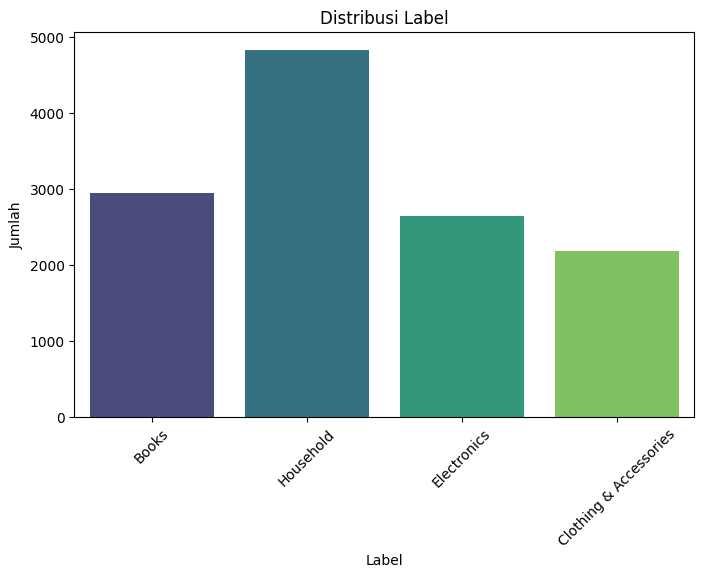

In [70]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, palette='viridis')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.xticks(rotation=45)
plt.show()

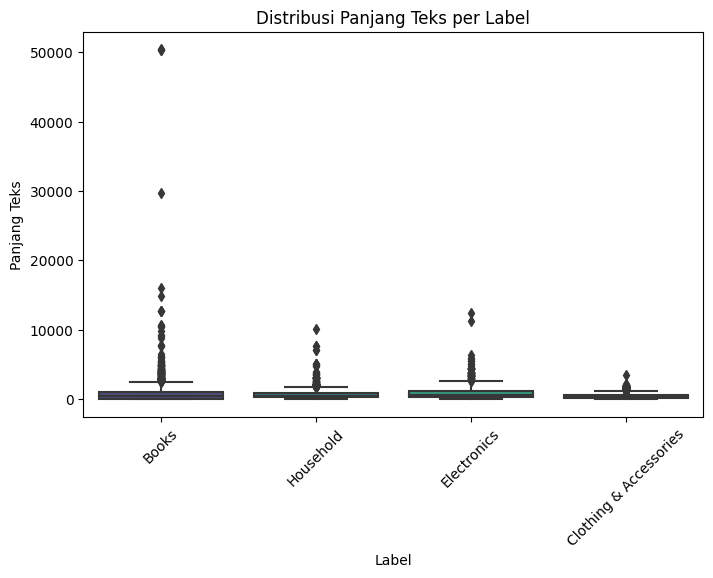

In [71]:
df['text'] = df['text'].fillna("")
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='text_length', data=df, palette='viridis')
plt.title("Distribusi Panjang Teks per Label")
plt.xlabel("Label")
plt.ylabel("Panjang Teks")
plt.xticks(rotation=45)
plt.show()

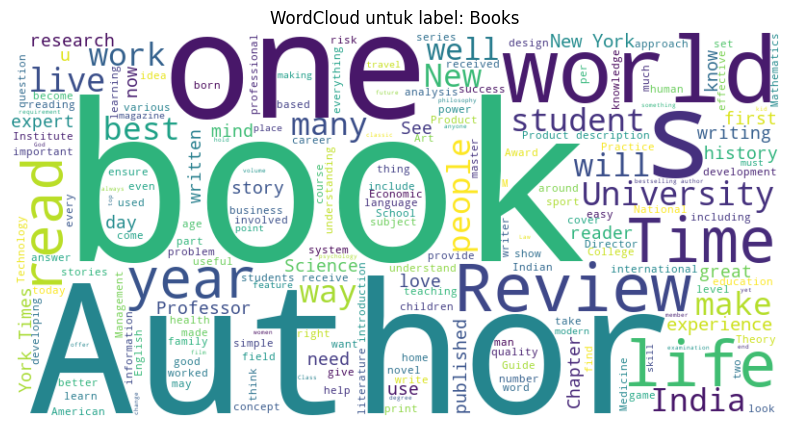

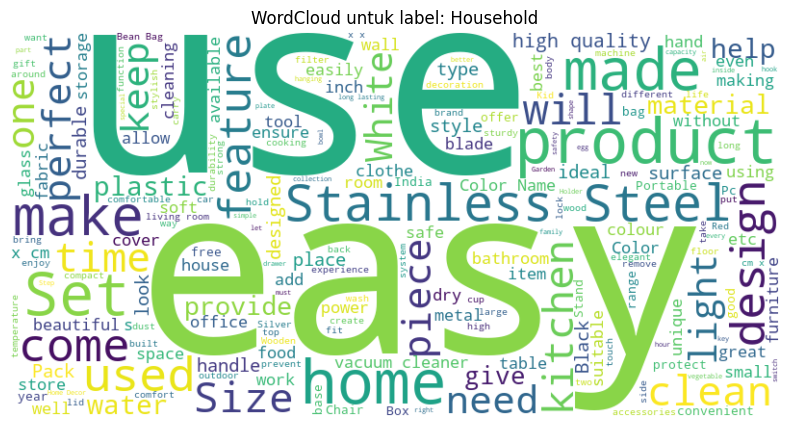

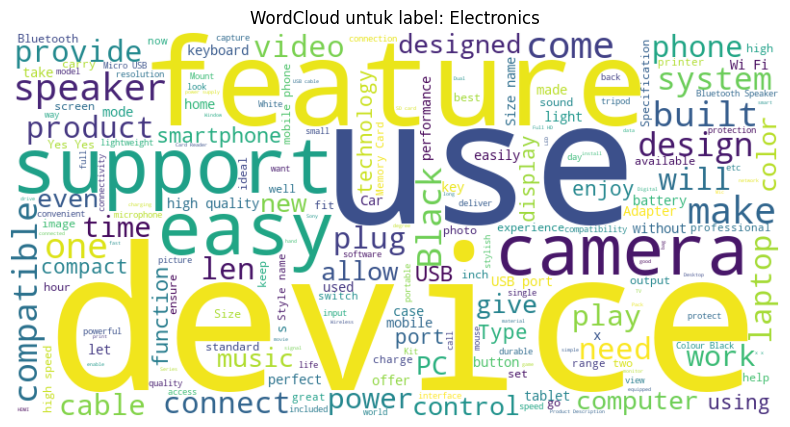

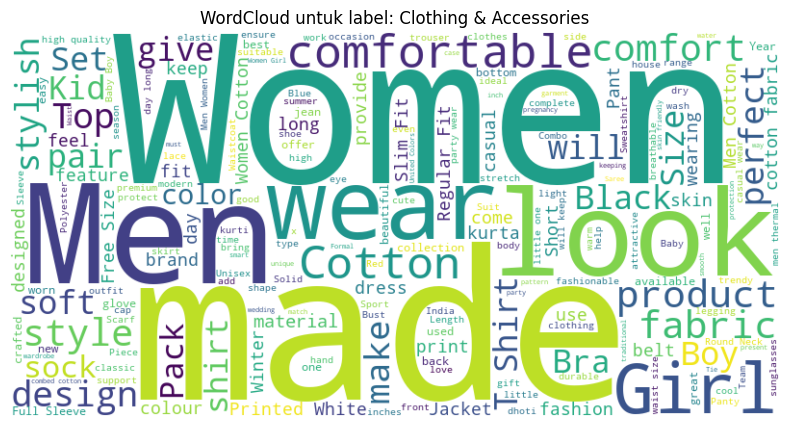

In [72]:
labels = df['label'].unique()

for label in labels:
    subset = df[df['label'] == label]
    text = " ".join(subset['text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud untuk label: {label}")
    plt.show()

In [73]:
df['text'] = df['text'].fillna('')

In [74]:
def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df['text'] = df['text'].apply(clean_text)

df.sample(5)

,text,label,text_length
20,cubetek hd media player p black cubetek hd med...,Electronics,600
5186,refrigerator net bagmesh storage bags for vege...,Household,803
10618,lg kg semiautomatic top loading washing machin...,Household,540
784,novahome ecom gsm premium cotton set of hand t...,Household,593
2952,momtobe womens cotton blue cream maternity dre...,Clothing & Accessories,877


In [75]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [76]:
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))
df.sample(5)

,text,label,text_length
9425,hokipo magic sticker series selfadhesive water...,Household,983
3913,freemans shshox belt clip steel plastic abs mm...,Household,305
2545,time plastics classic mixing bowl set pieces m...,Household,732
5409,rider women compression tshirt top full sleeve...,Clothing & Accessories,790
5661,halonix inverter led bulb b watt white pack st...,Household,299


In [77]:
label_encoder = LabelEncoder()

# Fit and transform the labels in the DataFrame
df['label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,text_length
0,theory everything review stephen hawkings theo...,0,4009
1,computer networks top approach author behrouz ...,0,129
2,sajani premium quality brown wooden coat hange...,3,1916
3,bosch lifestyle mcmm watt food processor black...,3,440
4,secret wish womens navyblue towel bathrobe fre...,3,182


In [78]:
label_mapping = {label: index for index, label in enumerate(label_encoder.classes_)}
label_mapping

{'Books': 0, 'Clothing & Accessories': 1, 'Electronics': 2, 'Household': 3}

In [79]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

df['text_lemmatized'] = df['text'].apply(lemmatize_text)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [81]:
pipeline_svm_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())  # Model SVM dengan parameter default
])

pipeline_rf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))  # Model Random Forest dengan parameter default
])

In [82]:
pipeline_svm_tfidf.fit(X_train, y_train)

# Prediksi
y_pred_svm = pipeline_svm_tfidf.predict(X_test)

# Evaluasi kinerja
print("Classification Report for SVM with TF-IDF:")
print(classification_report(y_test, y_pred_svm))

Classification Report for SVM with TF-IDF:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       586
           1       0.98      0.95      0.96       466
           2       0.97      0.93      0.95       506
           3       0.94      0.98      0.96       964

    accuracy                           0.96      2522
   macro avg       0.96      0.95      0.96      2522
weighted avg       0.96      0.96      0.96      2522



In [83]:
pipeline_rf_tfidf.fit(X_train, y_train)

# Prediksi
y_pred_rf = pipeline_rf_tfidf.predict(X_test)

# Evaluasi kinerja
print("Classification Report for Random Forest with TF-IDF:")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest with TF-IDF:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       586
           1       0.95      0.93      0.94       466
           2       0.96      0.89      0.92       506
           3       0.91      0.96      0.93       964

    accuracy                           0.93      2522
   macro avg       0.94      0.93      0.93      2522
weighted avg       0.93      0.93      0.93      2522



In [84]:
pipeline_svm_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf', SVC())  # Model SVM dengan parameter default
])

In [85]:
pipeline_svm_count.fit(X_train, y_train)

# Prediksi
y_pred_svm_count = pipeline_svm_count.predict(X_test)

# Evaluasi kinerja
print("Classification Report for SVM with Count Vectorization:")
print(classification_report(y_test, y_pred_svm_count))

Classification Report for SVM with Count Vectorization:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       586
           1       0.97      0.92      0.94       466
           2       0.96      0.86      0.91       506
           3       0.92      0.94      0.93       964

    accuracy                           0.92      2522
   macro avg       0.93      0.92      0.92      2522
weighted avg       0.92      0.92      0.92      2522



In [86]:
pipeline_rf_count = Pipeline([
    ('count', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))  # Model Random Forest dengan parameter default
])

In [87]:
pipeline_rf_count.fit(X_train, y_train)

# Prediksi
y_pred_rf_count = pipeline_rf_count.predict(X_test)

# Evaluasi kinerja
print("Classification Report for Random Forest with Count Vectorization:")
print(classification_report(y_test, y_pred_rf_count))

Classification Report for Random Forest with Count Vectorization:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       586
           1       0.95      0.93      0.94       466
           2       0.96      0.91      0.93       506
           3       0.92      0.96      0.94       964

    accuracy                           0.94      2522
   macro avg       0.94      0.93      0.94      2522
weighted avg       0.94      0.94      0.94      2522



In [88]:
svm_param_grid = {
    'clf__C': [0.1, 1, 10],  # Regularization parameter
    'clf__gamma': ['scale', 'auto'],  # Kernel coefficient
}

In [89]:
grid_svm = GridSearchCV(pipeline_svm_tfidf, svm_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__gamma': ['scale', 'auto']},
             scoring='f1_macro')

In [90]:
y_pred_svm_best = grid_svm.predict(X_test)

# Evaluasi kinerja
print("Best parameters for SVM:", grid_svm.best_params_)
print("Classification Report for SVM with TF-IDF after tuning:")
print(classification_report(y_test, y_pred_svm_best))

Best parameters for SVM: {'clf__C': 10, 'clf__gamma': 'scale'}
Classification Report for SVM with TF-IDF after tuning:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       586
           1       0.97      0.95      0.96       466
           2       0.97      0.94      0.95       506
           3       0.95      0.98      0.96       964

    accuracy                           0.96      2522
   macro avg       0.96      0.95      0.96      2522
weighted avg       0.96      0.96      0.96      2522



In [91]:
rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],  # Jumlah pohon dalam hutan
    'clf__max_depth': [None, 10, 20, 30],  # Kedalaman maksimum pohon
}

In [92]:
grid_rf = GridSearchCV(pipeline_rf_tfidf, rf_param_grid, cv=5, n_jobs=-1, scoring='f1_macro')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20, 30],
                         'clf__n_estimators': [50, 100, 200]},
             scoring='f1_macro')

In [93]:
y_pred_rf_best = grid_rf.predict(X_test)

In [94]:
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Classification Report for Random Forest with TF-IDF after tuning:")
print(classification_report(y_test, y_pred_rf_best))

Best parameters for Random Forest: {'clf__max_depth': None, 'clf__n_estimators': 100}
Classification Report for Random Forest with TF-IDF after tuning:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       586
           1       0.95      0.93      0.94       466
           2       0.96      0.89      0.92       506
           3       0.91      0.96      0.93       964

    accuracy                           0.93      2522
   macro avg       0.94      0.93      0.93      2522
weighted avg       0.93      0.93      0.93      2522

